In [1]:
import keras.backend as K
from keras import Input, Model, Sequential
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.callbacks import *

from matplotlib import pyplot as plt
import json

import sys
sys.path.append("..")
from generative_models import utils

from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor

from sklearn import metrics
import itertools
import random

import metrics_utils

/home/luca/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def build_nn_classifier():
    model_inputs = Input((timesteps,))
    classified = model_inputs

    classified = Dense(45, activation='relu')(classified)
    classified = Dense(15, activation='relu')(classified)
    classified = Dense(1, activation = 'sigmoid')(classified) 

    classifier = Model(model_inputs, classified, 'classifier')
    classifier.compile(loss='binary_crossentropy', optimizer='adam') 
    return classifier

def build_nn_regressor():
    model_inputs = Input((timesteps - targets,))
    regressed = model_inputs

    regressed = Dense(15, activation='relu')(regressed)
    regressed = Dense(5, activation='relu')(regressed)
    regressed = Dense(targets, activation = 'tanh')(regressed) 

    regressor = Model(model_inputs, regressed, 'regressor')
    regressor.compile(loss='mse', optimizer='adam') 
    return regressor
    
def build_classifiers(classifiers_list):
    if 'nn' in classifiers_list:
        assert classifiers_list[0] == 'nn'
    
    classifiers = []
    for classifier in classifiers_list:
        if classifier == 'nn':
            classifiers.append(build_nn_classifier())
        if classifier == 'svm':
            classifiers.append(SVC())
        if classifier == 'rf':
            classifiers.append(RandomForestClassifier())
        if classifier == 'dt':
            classifiers.append(DecisionTreeClassifier())
    return classifiers

def build_regressors(regressors_list):
    if 'nn' in regressors_list:
        assert regressors_list[0] == 'nn'
    
    regressors = []
    for regressor in regressors_list:
        if regressor == 'nn':
            regressors.append(build_nn_regressor())
        if regressor == 'svm':
            regressors.append(MultiOutputRegressor(SVR()))
        if regressor == 'rf':
            regressors.append(RandomForestRegressor())
        if regressor == 'dt':
            regressors.append(DecisionTreeRegressor())
    return regressors

def postprocess_dataset(reference_data, generated_data):
    step = 0.1
    generated_data = np.around(generated_data, 4)
    zero_value = metrics_utils.get_mode(reference_data)
    metrics_utils.postprocess_dataset(generated_data, zero_value, step)
    
def evaluate_data_classification(real_data, generated_data, classifiers_list):
    postprocess_dataset(real_data, generated_data)
    (x_train, y_train), (x_test, y_test) = metrics_utils.combine_data(real_data, generated_data, split)
    
    classifiers = build_classifiers(classifiers_list)
    
    if 'nn' in classifiers_list:
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)
        classifiers[0].fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, verbose=0, callbacks=[early_stopping])

    for i, classifier in enumerate(classifiers[1:]):
        classifier.fit(x_train, y_train)
     
    histories = {}
    for i, classifier in enumerate(classifiers):
        classifier_name = classifiers_list[i]
        y_pred = classifier.predict(x_test)
        
        f1_score = metrics.f1_score(y_test, np.rint(y_pred))
        accuracy = metrics.accuracy_score(y_test, np.rint(y_pred))
        histories[classifier_name] = {
            'f1_score':f1_score,
            'accuracy':accuracy
        }
        
    return histories

def evaluate_data_regression(real_data, generated_data, regressors_list, targets):
    postprocess_dataset(real_data, generated_data)
    (x_train, y_train), (x_test, y_test) = metrics_utils.combine_data_regression(real_data, generated_data, split, targets)
    
    regressors = build_regressors(regressors_list)
    
    if 'nn' in regressors_list:
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)
        regressors[0].fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, verbose=0, callbacks=[early_stopping])

    for i, regressor in enumerate(regressors[1:]):
        regressor.fit(x_train, y_train)
     
    histories = {}
    for i, regressor in enumerate(regressors):
        regressor_name = regressors_list[i]
        y_pred = regressor.predict(x_test)
    
        mse = metrics.mean_squared_error(y_test, y_pred)
        r2 = metrics.r2_score(y_test, y_pred)
        histories[regressor_name] = {
            'mse':mse,
            'r2':r2
        }
        
    return histories

def run_comparison(real_data, generated_data_filepaths, labels, models_list, targets):
    histories_classification = {}
    histories_regression = {}

    for index, filepath in enumerate(generated_data_filepaths):
        print(labels[index])
        generated_data = np.load(filepath)[:elements]
        history_classification = evaluate_data_classification(real_data, generated_data, models_list)
        history_regression = evaluate_data_regression(real_data, generated_data, models_list, targets)
        histories_classification[labels[index]] = history_classification
        histories_regression[labels[index]] = history_regression
    return histories_classification, histories_regression

In [3]:
timesteps = 90
elements = 5000
split = 0.3
targets = 20

transactions_filepath = '../../datasets/berka_dataset/usable/normalized_transactions_months.npy'
real_data = utils.load_splitted_dataset(transactions_filepath, timesteps)[:elements]
models_list = ['nn', 'rf', 'svm', 'dt']

## Models comparison

In [4]:
labels = ['vanilla', 'mbd', 'packing']
title = 'models_comparison'

base_filepath = '../generative_models/wgan_gp/outputs/final/'
end_filename = 'generated_datasets/1000000_generated_data.npy'    
generated_data_filepaths = []    
for label in labels:
    generated_data_filepaths.append(base_filepath + label + '/' + end_filename)
    
histories_classification, histories_regression = run_comparison(real_data, generated_data_filepaths, labels, models_list, targets)
metrics_utils.plot_metrics(histories_classification, labels, title)
metrics_utils.plot_metrics(histories_regression, labels, title)

metrics_utils.save_to_json('classification_scores.json', histories_classification)
metrics_utils.save_to_json('regression_scores.json', histories_regression)

vanilla


KeyboardInterrupt: 

## Performance analysis during training

In [5]:
labels = ['100k', '200k', '300k', '400k', '500k', '600k', '700k', '800k', '900k', '1M']

transactions_filepath = '../../datasets/berka_dataset/usable/normalized_transactions_months.npy'
real_data = utils.load_splitted_dataset(transactions_filepath, timesteps)[:elements]

### Vanilla

100k
200k
300k
400k
500k
600k
700k
800k
900k
1M


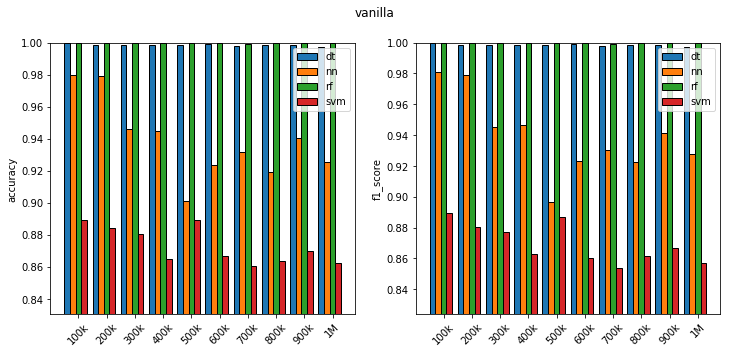

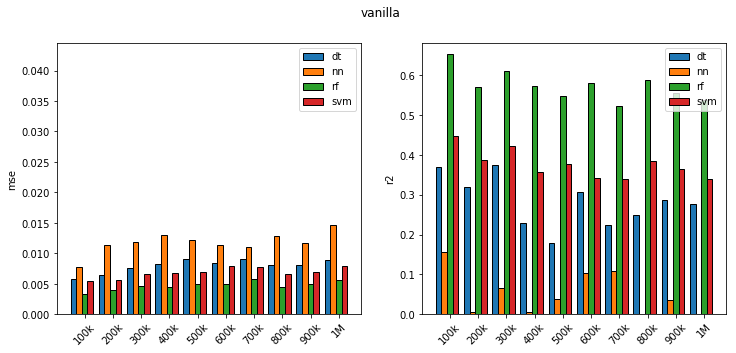

In [7]:
title = 'vanilla'

base_filepath = '../generative_models/wgan_gp/outputs/final/vanilla/generated_datasets/'
generated_data_filepaths = []
for n in range(100000, 1000001, 100000):
    generated_data_filepaths.append(base_filepath + str(n) + '_generated_data.npy')
    
histories_classification, histories_regression = run_comparison(real_data, generated_data_filepaths, labels, models_list, targets)
metrics_utils.plot_metrics(histories_classification, labels, title)
metrics_utils.plot_metrics(histories_regression, labels, title)

metrics_utils.save_to_json('classification_vanilla.json', histories_classification)
metrics_utils.save_to_json('regression_vanilla.json', histories_regression)

### Mbd

100k
200k
300k
400k
500k
600k
700k
800k
900k
1M


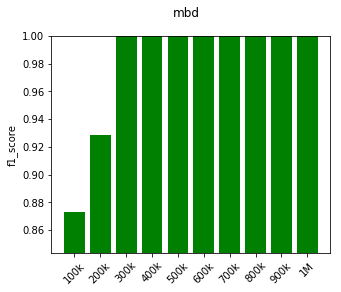

In [7]:
title = 'mbd'

base_filepath = '../generative_models/wgan_gp/outputs/final/mbd/generated_datasets/'
generated_data_filepaths = []
for n in range(100000, 1000001, 100000):
    generated_data_filepaths.append(base_filepath + str(n) + '_generated_data.npy')
    
histories = run_comparison(real_data, generated_data_filepaths, labels)
metrics_utils.plot_metrics(histories, labels, title)

metrics_utils.save_to_json('rf_classification_mbd.json', histories)

### Packing

100k
200k
300k
400k
500k
600k
700k
800k
900k
1M


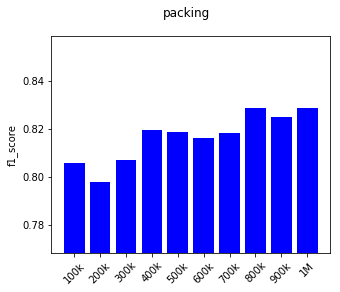

In [8]:
colors = [packing_color] * 10
title = 'packing'

base_filepath = '../generative_models/wgan_gp/outputs/final/packing/generated_datasets/'
generated_data_filepaths = []
for n in range(100000, 1000001, 100000):
    generated_data_filepaths.append(base_filepath + str(n) + '_generated_data.npy')
    
histories = run_comparison(real_data, generated_data_filepaths, labels)
metrics_utils.plot_metrics(histories, labels, colors, title)

metrics_utils.save_to_json('rf_classification_packing.json', histories)